## CS436/5310/EE513 - Fall 2024 - PA4 (Part 2)

#### Important Instructions and Submission Guidelines:
- Naming convention for submission of this notebook is `RollNumber_PA4_Part2.ipynb` where. For example: `25100149_PA4_Part2.ipynb`
- All the cells <b>must</b> be run once before submission. If your submission's cells are not showing the results (plots etc.), marks wil be deducted
- Only the code written within this notebook's marked areas will be considered while grading. No other files will be entertained
- You are advised to follow good programming practies including approriate variable naming and making use of logical comments 


The university honor code should be maintained. Any violation, if found, will result in disciplinary action. 

#### Common imports



In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def click_event(event, x, y, flags, param):
    points = param['points']
    img = param['img']
    max_points = param['max_points']
    
    if event == cv2.EVENT_LBUTTONDOWN:
        if len(points) < max_points:
            points.append((x, y))  # Append the new point to the points list

            # Draw a small circle at the point
            cv2.circle(img, (x, y), 2, (0, 0, 255), -1)

            # Draw the point number near the point
            point_number = len(points)
            cv2.putText(img, str(point_number), (x + 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

            # Update the display
            cv2.imshow("image", img)
            
        if len(points) == max_points:
            cv2.destroyAllWindows()

def point_reader(img, max_points):
    '''
    img - The image to be marked points on
    '''
    points = []  # Initialize a new, empty list for points
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imshow('image', img)
    
    # Create a parameter dictionary to pass the image and points list
    param = {'points': points, 'img': img, 'max_points': max_points}
    
    # Set the callback function for mouse events
    cv2.setMouseCallback('image', click_event, param)
    
    # Wait until a key is pressed and the window is closed
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    # Return the list of points as a numpy array
    return np.array(points, dtype=np.int32), img

# Shows image
def show_image(image):
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# Labels O, X, Y, and Z axis of an image
def label_image(image, num_labels):
    labelled_image = image.copy()
    xyz_points, labelled_image = point_reader(labelled_image, num_labels)
    labelled_image = cv2.cvtColor(labelled_image, cv2.COLOR_BGR2RGB)
    
    # Initializing origin, x, y, z coordinates
    if len(xyz_points) >= 1:
        o = (int(xyz_points[0, 0]), int(xyz_points[0, 1]))
    if len(xyz_points) >= 2:
        x = (int(xyz_points[1, 0]), int(xyz_points[1, 1]))
    if len(xyz_points) >= 3:
        y = (int(xyz_points[2, 0]), int(xyz_points[2, 1]))
    if len(xyz_points) >= 4:
        z = (int(xyz_points[3, 0]), int(xyz_points[3, 1]))
    
    # Drawing arrows for x, y, z axis
    thickness = 2
    labelled_image = cv2.arrowedLine(labelled_image, o, x, (0, 255, 0), thickness, tipLength=0.05)
    labelled_image = cv2.arrowedLine(labelled_image, o, y, (0, 255, 0), thickness, tipLength=0.05)
    labelled_image = cv2.arrowedLine(labelled_image, o, z, (0, 255, 0), thickness, tipLength=0.05)
    
    # Adding labels near the end of each arrow
    font_scale = 1
    thickness = 2
    offset = 10
    cv2.putText(labelled_image, 'X', (x[0]+offset, x[1]-offset), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), thickness, cv2.LINE_AA)
    cv2.putText(labelled_image, 'Y', (y[0]+offset, y[1]-offset), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), thickness, cv2.LINE_AA)
    cv2.putText(labelled_image, 'Z', (z[0]+offset, z[1]-offset), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), thickness, cv2.LINE_AA)

    return xyz_points, labelled_image

# Projects the world points from 3D to 2D
def project_world_points(world_points):
    # Making world coordinates from [N, 3] -> [N, 4]
    world_points_homogenous = np.hstack((world_points, np.ones((world_points.shape[0], 1))))
    
    # Projecting the points: ([3, 4] x [4, N]) -> [3, N].T -> [N, 3]
    projected_points = (P @ world_points_homogenous.T).T
    
    # Normalizing and extracting x and y points
    projected_points = projected_points[:, :2] / projected_points[:, 2:3]
    
    return projected_points

# Calculates the difference between image and world-projected points
def calculate_error(image_points, projected_world_points):
    error = np.mean(np.linalg.norm(image_points - projected_world_points, axis=1))
    return error 

# Displayes the image with marked points
def display_projected_points(image, image_points, projected_world_points):
    image = image.copy()
    radius = 5
    for (x_image, y_image), (x_projected, y_projected) in zip(image_points, projected_world_points):
        cv2.circle(image, (int(x_image), int(y_image)), radius, (0, 0, 255), -1)
        cv2.circle(image, (int(x_projected), int(y_projected)), radius, (0, 255, 0), -1)
        
    return image

# Calculates the euclidean distance between points
def calculate_distance(b, t):
    distance = np.linalg.norm(b - t)
    return distance


## Task - 01  (40 MARKS)

In this task, you’ll be calculating the camera matrix of your own phone.
- Capture an image of a 3D object (i.e. a nonplanar object, a box of tissue paper for example) with your camera phone. 
- Mark the world points on that object in the image as carefully as possible and establish their world coordinates (in millimeters). 
- Use the point_reader() function to mark the image points. Mark at least 20 image points

From this data, compute the camera matrix P

### Defining the Axis (5 Marks)

Displaying the image:


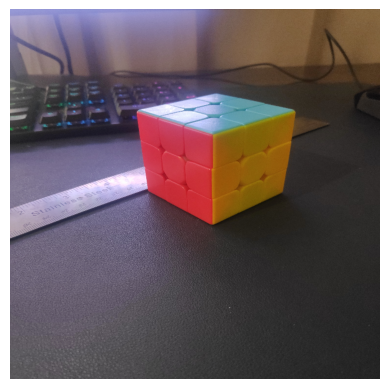

In [3]:
# Your code here to load and display image
image = cv2.cvtColor(cv2.imread('rubix_cube.jpg'), cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (720, 720))

print("Displaying the image:")
show_image(image)

Displaying the image with labelled axis:


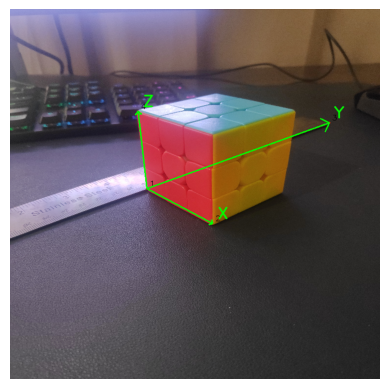

In [4]:
# Display the object along with the labelled x,y,z axis
xyz_points, labelled_image = label_image(image, 4)

print("Displaying the image with labelled axis:")
show_image(labelled_image)

### Marking 20 Image Points (5 Marks)
Use the `point_reader()` function from Task#00, and mark 20 points over the image.

Displaying the image marked with 28 points:


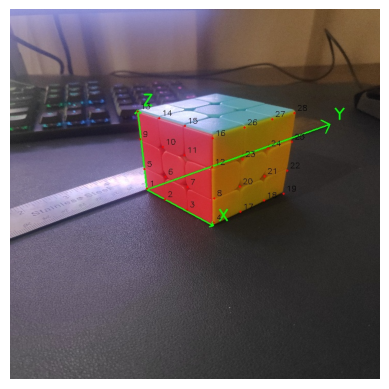

In [5]:
# Define your world coordinates and corresponding image coordinates

# marked_image = labelled_image.copy()
# image_points, marked_image = point_reader(cv2.cvtColor(marked_image, cv2.COLOR_RGB2BGR))
# show_image(cv2.cvtColor(marked_image, cv2.COLOR_BGR2RGB))
# cv2.imwrite("marked_image.jpg", marked_image)

# Used point reader to get image_points and marked_image and then saved them as seperate variables/images.
image_points = np.array([
    [266, 349],
    [301, 370],
    [344, 390],
    [396, 415],
    [261, 311],
    [302, 326],
    [345, 346],
    [397, 368],
    [253, 253],
    [297, 268],
    [339, 284],
    [393, 307],
    [248, 199],
    [290, 212],
    [340, 227],
    [394, 251],
    [448, 394],
    [494, 372],
    [532, 359],
    [447, 345],
    [495, 325],
    [539, 314],
    [452, 292],
    [502, 271],
    [548, 258],
    [456, 230],
    [510, 214],
    [553, 202],
    ])
print(f"Displaying the image marked with {len(image_points)} points:")
show_image(cv2.cvtColor(cv2.imread('marked_image.jpg'), cv2.COLOR_BGR2RGB))

### Establishing World Coordinates in Millimeters (5 Marks)
Define your co-ordinate system (3D) in the image and mark points (in mm)

In [6]:
cube_height = 55 # mm
each_square_side = cube_height/3.

# Initialing world points
world_points = np.array([
    [0, 0, 0],
    [1, 0, 0],
    [2, 0, 0],
    [3, 0, 0],
    
    [0, 0, 1],
    [1, 0, 1],
    [2, 0, 1],
    [3, 0, 1],
    
    [0, 0, 2],
    [1, 0, 2],
    [2, 0, 2],
    [3, 0, 2],
    
    [0, 0, 3],
    [1, 0, 3],
    [2, 0, 3],
    [3, 0, 3],
    
    [3, 1, 0],
    [3, 2, 0],
    [3, 3, 0],
    
    [3, 1, 1],
    [3, 2, 1],
    [3, 3, 1],
    
    [3, 1, 2],
    [3, 2, 2],
    [3, 3, 2],
    
    [3, 1, 3],
    [3, 2, 3],
    [3, 3, 3],
])

# Converting world points to mm
world_points = np.array(world_points) * each_square_side

### Computing Camera Matrix P (15 Marks)

- Refer to the Camera Calibration lecture slides for exact instructions on how to calculate the P Matrix.


In [7]:
def compute_camera_matrix(world_points, image_points):
    # Compute the camera matrix P using SVD
    
    C_matrix = []
    for world_point, image_point in zip(world_points, image_points):
        X, Y, Z = world_point
        x, y = image_point
        
        C_matrix.append([X, Y, Z, 1, 0, 0, 0, 0, -x*X, -x*Y, -x*Z, -x])
        C_matrix.append([0, 0, 0, 0, X, Y, Z, 1, -y*X, -y*Y, -y*Z, -y])
        
    C_matrix = np.array(C_matrix)
    
    # Computing the camera matrix: Ca=0 
    # -> svd of C 
    # -> column of Vt corresponding to singular value of zero is the solution 
    # -> smallest eigen value
    U, S, Vt = np.linalg.svd(C_matrix)
    flattened_p = Vt[-1, :] # Vt.T[:, -1] -> last column of Vt
    P = flattened_p.reshape(3, 4)
    
    return P

P = compute_camera_matrix(world_points, image_points)

### Decompose the Camera Matrix (5 Marks)

Decompose the camera matrix \(P\) into intrinsic parameters \(K\), rotation matrix \(R\), and translation vector \(t\).


In [8]:
def decompose_camera_matrix(P):
    # Decompose camera matrix P into K (intrinsic), R (rotation), and t (translation).\n",
    
    # Solving camera center: null vector of P
    U, S, Vt = np.linalg.svd(P)
    C = Vt[-1, :] / Vt[-1, -1]
    
    # Solving for K and R: P_(3x3) = KR -> Solved through qr decomposition
    M = P[:, :-1]   # Extracting 3x3 matrix from M
    t = P[:, -1]    # Extracting translation matrix from M
    
    R, K = np.linalg.qr(M)
    K = K / K[-1, -1]
    
    return K, R, C, t
        
K, R, C, t = decompose_camera_matrix(P)
print("Projection Matrix: \n", P)
print("\nIntrinsic Matrix: \n", K)
print("\nRotation Matrix: \n", R) 
print("\nCamera Centre:", C)

Projection Matrix: 
 [[ 2.72393645e-03  7.76043545e-03 -2.15949241e-03  6.04402267e-01]
 [-9.26956421e-06 -9.91398240e-05 -7.33350725e-03  7.96596914e-01]
 [-6.55464618e-06  5.56119173e-06 -5.52377610e-06  2.27106910e-03]]

Intrinsic Matrix: 
 [[ 1.16867427  3.32960864 -0.91577723]
 [-0.         -0.03289083 -2.98649583]
 [-0.         -0.          1.        ]]

Rotation Matrix: 
 [[-0.99999131 -0.00246774  0.00335868]
 [ 0.00340297 -0.94871083  0.31612685]
 [ 0.00240629  0.31613554  0.94871098]]

Camera Centre: [ 164.71916741 -105.13506105  109.83736473    1.        ]



### Reprojection Error Calculation (5 Marks)

Using the camera matrix \(P\), reproject the known 3D world points onto the 2D image plane.

- Calculate the average difference between the Actual `(x'/h, y'/h)` and the ones you get by multiplying your camera matrix with each `(x,y,1)`.
- Display the image with the original points, and the reprojected points in a different color


Error: 2.803


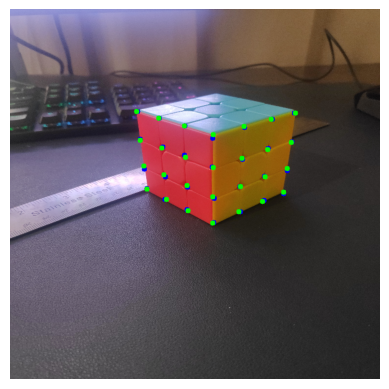

Projected points are in GREEN.
Actual points are in BLUE.


In [9]:
# Projecting the world points from 3D to 2D
projected_world_points = project_world_points(world_points)

# Calculating the error between the original image points and the reprojected world points
error = calculate_error(image_points, projected_world_points)
print(f"Error: {error:.3f}")

# Displaying projected world coordinates onto original image
show_image(display_projected_points(image, image_points, projected_world_points))
print("Projected points are in GREEN.")
print("Actual points are in BLUE.")


## Task - 02: Height Estimation using Known Height (20 Marks)

**Objective**:  
Take an image of a scene with multiple objects, including an object of known height (Like a desk), calculate the height of a second object in the image using `Algorithm 8.1`.

**Instructions**:
- Using the provided height as your reference, apply Algorithm 8.1 to estimate the height of the second object in the image.
- Clearly label your calculations and any assumptions.

**Note:** Ignore any perspective distortion in the image taken. You are not required to correct perspective distortion in the image.


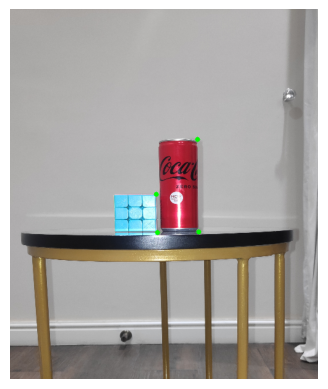

Euclidean distance of the rubix cube from base to top: 62.032

Euclidean distance of can from base to top: 150.013

Height of the coca cola can is: 133.007mm


In [10]:
multiple_objects = cv2.cvtColor(cv2.imread('multiple_objects.jpg'), cv2.COLOR_BGR2RGB)
multiple_objects = cv2.resize(multiple_objects, (500, 600))
cube_height = 55 # mm

# Cube base and top values
# L1, obj1_segment = point_reader(multiple_objects, 2)
L1 = np.array([
    [239, 362],
    [237, 300],
    ])

# Can base and top values
# L2, obj2_segment = point_reader(multiple_objects, 2)
L2 = np.array([
    [306, 361],
    [304, 211],
    ])

# Marks the image with points
def mark_image(point_array, image):
    image_c = image.copy()
    radius = 4
    for point in point_array:
        x, y = point 
        cv2.circle(image_c, (int(x), int(y)), radius, (0, 250, 0), -1)
        
    return image_c

marked_image = mark_image(L1, multiple_objects)
marked_image = mark_image(L2, marked_image)
show_image(marked_image)

# Extracting base and top coordinates of each line segment
b1, t1 = L1 # cube
b2, t2 = L2 # can

d1 = calculate_distance(b1, t1)
print(f"Euclidean distance of the rubix cube from base to top: {d1:.3f}\n")

d2 = calculate_distance(b2, t2)
print(f"Euclidean distance of can from base to top: {d2:.3f}\n")

# Calculating ratios
ratio1 = d2/d1
ratio2 = t2/t1

unknown_height = ratio1 * cube_height
print(f"Height of the coca cola can is: {unknown_height:.3f}mm")

![Getting Started](coca_cola_height.png)
